# Lyapunov

This notebook is for calculating lyapunov exponets for the system.

In [1]:
from modules.helper import *
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

tolerence = 1e-1

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

# Calculating the Lyapunov Exponents.

Let's start by generating a 4D grid for x, y, a, and $\lambda$.

In [3]:
x = np.linspace(-7,7,10)
y = np.linspace(-7,7,10)
l = np.linspace(0.5,1,10)
a = np.linspace(0.5,1,10)

dl = l[-1]-l[-2]
I = len(l)
A = len(a)

n_transient = 10000
n_attractor = 1000

x,y,l,a = np.meshgrid(x,y,l,a)

Now we have our dataset, we want to iterate it over time to get an initial condition which is inside the attractor.

In [4]:
X, Y = repeatmap(x,y,l,a,n=int(n_transient), nosave = True)

Progress: [####################] 99.0%


Let's iterate this for another 1000 steps to get a representitive sample of the chaotic attractor.

In [5]:
X_attractor,Y_attractor = repeatmap(X,Y,l,a,n=int(n_attractor), nosave = False)

Progress: [##################--] 90.0%


Selecting a random angle ($\phi$) between 0 and $2\pi$, we use this as an initial displacement vector for the first timestep of the sequence in each attractor.

In [6]:
phi = np.random.uniform(0,2*np.pi,list(X_attractor.shape)[1:])
print(phi.shape)
# plt.imshow(phi)
# plt.colorbar()
# plt.show()

(10, 10, 10, 10)


In [7]:
E = np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
J = jacobian(X_attractor,Y_attractor,l,a)
print(J.shape, E.shape)

(1000, 10, 10, 10, 10, 2, 2) (2, 2, 10, 10, 10, 10)


Below is an attempt to loop over all the points and compute their trajectories individually. This has been abandonded due to being 100 times slower than the vectorised method below.

In [8]:
time0 = time.time()
lyapunov_1 = np.zeros(list(E.shape)[2:])
lyapunov_2 = np.zeros(list(E.shape)[2:])


angle_matrix     = E
first_exponent   = np.zeros([n_attractor, *list(E.shape)[2:]])
sum_of_exponents = np.zeros([n_attractor, *list(E.shape)[2:]])

# Iterating over given time
for t in range(n_attractor):
    
    # Subsetting the jacobian matrix
    jacobian_matrix = J[t]
    
    # rotating the angle matrix
    angle_matrix = np.einsum('xylaij,jkxyla->ikxyla',jacobian_matrix, angle_matrix)
    
    # Calculating the Lyapunov Exponents
    first_exponent[t] = np.linalg.norm(angle_matrix[:,0], axis=0)
    sum_of_exponents[t] = np.linalg.det(np.einsum('ijxyla->xylaij', angle_matrix))
    
    # Renormalising
    angle_matrix = vectorGSchmidt(angle_matrix)
    
    # Progress Bar
    if t % 100 == 0:
        update_progress(t/n_attractor)
    
lyapunov_1 = np.mean(np.log(first_exponent), axis=0)
lyapunov_2 = np.mean(np.log(sum_of_exponents), axis=0)   
print('This took {:.02f} seconds to run'.format(time.time()-time0))

Progress: [##################--] 90.0%
This took 5.14 seconds to run


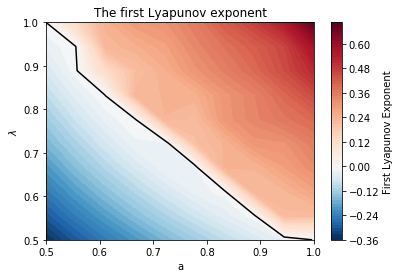

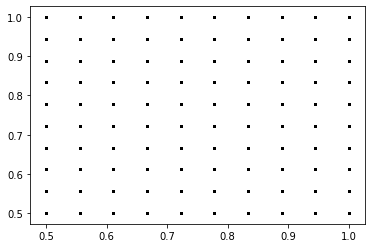

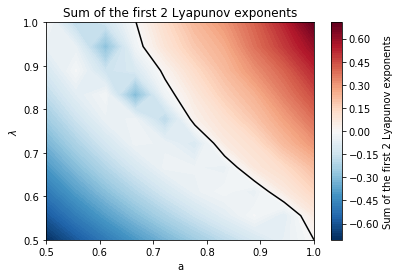

In [9]:
import matplotlib.colors as colors
i = 5
j = 5

fig, ax = plt.subplots()
divnorm = colors.DivergingNorm(vmin=lyapunov_1.min(), vcenter=0, vmax=lyapunov_1.max())
plt.contourf(a[0,0,0,:],l[0,0,:,0],lyapunov_1[i,j], levels = 100,cmap = 'RdBu_r', norm=divnorm)
cbar = plt.colorbar()
plt.contour(a[0,0,0,:],l[0,0,:,0],lyapunov_1[i,j], levels = [0,], colors=('k',))
plt.title('The first Lyapunov exponent')
plt.ylabel('$\lambda$')
plt.xlabel('a')
cbar.ax.set_ylabel('First Lyapunov Exponent')
plt.show()

fig, ax = plt.subplots()
plt.scatter(l,a, s=1,color='k')
plt.savefig('images/phase_space_density.pdf')
plt.show()

divnorm = colors.DivergingNorm(vmin=lyapunov_2.min(), vcenter=0, vmax=lyapunov_2.max())
plt.contourf(a[0,0,0,:],l[0,0,:,0],lyapunov_2[i,j], levels = 100, cmap = 'RdBu_r', norm=divnorm)
cbar = plt.colorbar()
plt.contour(a[0,0,0,:],l[0,0,:,0],lyapunov_2[i,j], levels = [0,], colors=('k',))
# plt.scatter(l,a,color='k')

plt.title('Sum of the first 2 Lyapunov exponents')
plt.ylabel('$\lambda$')
plt.xlabel('a')
cbar.ax.set_ylabel('Sum of the first 2 Lyapunov exponents')
plt.show()

# Comparing with other results

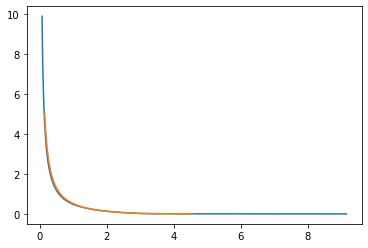

In [10]:
chaos = np.loadtxt('data/chaos_al.dat')
plt.plot(chaos[:,0],chaos[:,1])

wild_chaos = np.loadtxt('data/wildchaos_al.dat')
plt.plot(wild_chaos[:,0],wild_chaos[:,1])
plt.show()

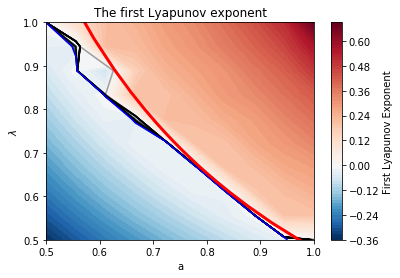

In [11]:
fig, ax = plt.subplots()
divnorm = colors.DivergingNorm(vmin=lyapunov_1.min(axis=0).min(axis=0).min(), vcenter=0, vmax=lyapunov_1.max())
plt.contourf(a[0,0,0,:],l[0,0,:,0],lyapunov_1.min(axis=0).min(axis=0), levels = 100,cmap = 'RdBu_r', norm=divnorm)
cbar = plt.colorbar()
for i in range(lyapunov_2.shape[0]):
    for j in range(lyapunov_2.shape[1]):
        plt.contour(a[0,0,0,:],l[0,0,:,0],lyapunov_1[i,j], levels = [0,], colors=('k',),alpha=0.1)
plt.contour(a[0,0,0,:],l[0,0,:,0],lyapunov_1.max(axis=0).max(axis=0), levels = [0,], colors=('blue',),alpha=1)
plt.title('The first Lyapunov exponent')
plt.ylabel('$\lambda$')
plt.xlabel('a')
cbar.ax.set_ylabel('First Lyapunov Exponent')
plt.plot(chaos[:,0],chaos[:,1],'red',lw=3)
ax.set_ylim([l.min(),l.max()])
ax.set_xlim([a.min(),a.max()])
plt.savefig('images/first_lyapunov.pdf')
plt.show()

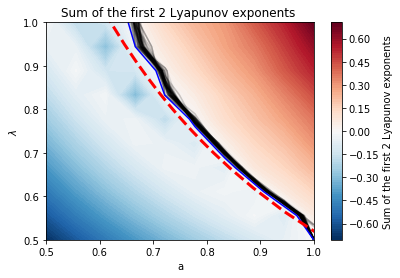

In [12]:
fig, ax = plt.subplots()

divnorm = colors.DivergingNorm(vmin=lyapunov_2[i,j].min(), vcenter=0, vmax=lyapunov_2.max())
plt.contourf(a[0,0,0,:],l[0,0,:,0],lyapunov_2[i,j], levels = 100, cmap = 'RdBu_r', norm=divnorm)
cbar = plt.colorbar()

plt.plot(wild_chaos[:,0],wild_chaos[:,1],'--r',lw=3)

for i in range(lyapunov_2.shape[0]):
    for j in range(lyapunov_2.shape[1]):
        plt.contour(a[0,0,0,:],l[0,0,:,0],lyapunov_2[i,j], levels = [0,], colors=('k',),alpha=0.1)
lyap_sum = plt.contour(a[0,0,0,:],l[0,0,:,0],lyapunov_2.max(axis=0).max(axis=0), levels = [0,], colors=('blue',),alpha=1)

dat0 = lyap_sum.allsegs[0][0]

plt.title('Sum of the first 2 Lyapunov exponents ')
plt.ylabel('$\lambda$')
plt.xlabel('a')
cbar.ax.set_ylabel('Sum of the first 2 Lyapunov exponents')

ax.set_ylim([l.min(),l.max()])
ax.set_xlim([a.min(),a.max()])
plt.savefig('images/sum_of_first_2_lyapunov.pdf')
plt.show()

In [13]:
dat0

array([[0.65320622, 1.        ],
       [0.66647071, 0.94444444],
       [0.66666667, 0.94388442],
       [0.70499872, 0.88888889],
       [0.72126647, 0.83333333],
       [0.72222222, 0.83179501],
       [0.76737452, 0.77777778],
       [0.77777778, 0.76041992],
       [0.80721914, 0.72222222],
       [0.83333333, 0.68853519],
       [0.85240844, 0.66666667],
       [0.88888889, 0.62863317],
       [0.9057206 , 0.61111111],
       [0.94444444, 0.57663482],
       [0.96820676, 0.55555556],
       [0.99964409, 0.5       ]])

(0.5, 1)

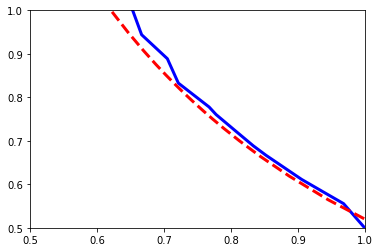

In [14]:
fig, ax = plt.subplots()
plt.plot(dat0[:,0],dat0[:,1],'b',lw=3)
plt.plot(wild_chaos[:,0],wild_chaos[:,1],'--r',lw=3)
ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1])

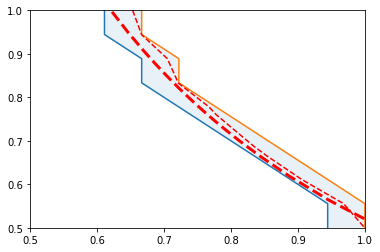

10


In [36]:
indicies = np.argwhere(np.diff(np.sign(lyapunov_2.max(axis=0).max(axis=0)),axis=1))

fig, ax = plt.subplots()

A1 = a[0,0,0,indicies[:,1]]
A2 = a[0,0,0,indicies[:,1]+1]
Z1 = lyapunov_2.max(axis=0).max(axis=0)[0,indicies[:,1]]
Z2 = lyapunov_2.max(axis=0).max(axis=0)[0,indicies[:,1]+1]

m = (A2-A1)/(Z2-Z1)
c = Z2 - m * (A2)
A3 = -c/m

plt.plot(A1,l[0,0,indicies[:,0],0])
plt.plot(A2,l[0,0,indicies[:,0],0])
plt.fill_betweenx(l[0,0,indicies[:,0],0], A1,A2, alpha=0.1)
plt.plot(wild_chaos[:,0],wild_chaos[:,1],'--r',lw=3)
plt.plot(dat0[:,0],dat0[:,1],'r--')

ax.set_xlim([0.5,1])
ax.set_ylim([0.5,1])
plt.show()

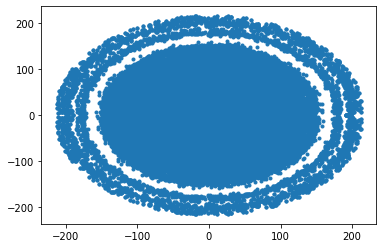

In [35]:
plt.plot(X_attractor.flatten(), Y_attractor.flatten(), '.')
plt.show()